<a href="https://colab.research.google.com/github/rumman-adnan/Assignment-Sensors-Data/blob/main/sensors_data_analytics_LSTM_both.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score



In [4]:
train_data = np.load('/content/drive/MyDrive/Python work/sim_data/simu_20000_0.1_90_140_train.npy')
test_data = np.load('/content/drive/MyDrive/Python work/sim_data/simu_10000_0.1_141_178_test.npy')

print("The shape of trained data is: ",train_data.shape)
print("The shape of tested data is: ",test_data.shape)

The shape of trained data is:  (20000, 1006)
The shape of tested data is:  (10000, 1006)


In [5]:
# Extraction of features and targets

# Training features and targets
X_train_lstm = train_data[:, :1000]
Y_train_lstm = train_data[:, -2:]

# Testing features and targets
X_test_lstm = test_data[:, :1000]
Y_test_lstm = test_data[:, -2:]

# Reshaping data for LSTM
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)


In [6]:
from sklearn.preprocessing import MinMaxScaler

# Initializing the scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scaling the features
X_train_scaled = feature_scaler.fit_transform(X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1]))
X_test_scaled = feature_scaler.transform(X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1]))
X_train_scaled = X_train_scaled.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

# Scaling the targets
Y_train_scaled = target_scaler.fit_transform(Y_train_lstm)
Y_test_scaled = target_scaler.transform(Y_test_lstm)





# Scaling features
X_train_scaled = feature_scaler.fit_transform(X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1]))
X_test_scaled = feature_scaler.transform(X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1]))
X_train_scaled = X_train_scaled.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

# Scaling targets
Y_train_scaled = target_scaler.fit_transform(Y_train_lstm)
Y_test_scaled = target_scaler.transform(Y_test_lstm)

X_train_scaled.shape, X_test_scaled.shape, Y_train_scaled.shape, Y_test_scaled.shape


((20000, 1000, 1), (10000, 1000, 1), (20000, 2), (10000, 2))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error

# Data shape is already suitable for LSTM: (batch_size, timesteps, features)
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Model Creation
model = Sequential()

# Adding LSTM layer optimized for cuDNN
model.add(LSTM(50, activation='tanh', recurrent_activation='sigmoid', input_shape=(X_train_lstm.shape[1], 1)))

# Dense layers for regression
model.add(Dense(50, activation='relu'))
model.add(Dense(2))  # Two output units for S and D

# Define optimizer and loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()

# Custom training loop
epochs = 500  # Maximum epochs
batch_size = 32
desired_mae = 3
steps_per_epoch = len(X_train_lstm) // batch_size

for epoch in range(epochs):
    print("\nEpoch {}/{}".format(epoch+1, epochs))

    for step in range(steps_per_epoch):
        # Create a batch of data
        X_batch = X_train_lstm[step*batch_size:(step+1)*batch_size]
        Y_batch = Y_train_SD[step*batch_size:(step+1)*batch_size]

        # Forward pass
        with tf.GradientTape() as tape:
            predictions = model(X_batch, training=True)
            loss_value = loss_fn(Y_batch, predictions)

        # Backward pass
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Evaluate after each epoch
    predictions = model(X_test_lstm)
    mae_scores = mean_absolute_error(Y_test_SD, predictions, multioutput='raw_values')
    print("MAE after epoch {}: {}".format(epoch+1, mae_scores))

    # If desired MAE is achieved, stop training
    if mae_scores[0] <= desired_mae and mae_scores[1] <= desired_mae:
        print("Desired MAE achieved. Stopping training.")
        break


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='tanh', recurrent_activation='sigmoid', input_shape=(X_train_scaled.shape[1], 1)))
model_lstm.add(Dense(50, activation='relu'))
model_lstm.add(Dense(2))  # Two output units for S and D

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Training the LSTM model
desired_mae = 3
best_mae = float('inf')
patience = 10  # Number of epochs to wait if no improvement before stopping
wait = 0

for epoch in range(500):  # Maximum epochs
    print(f"\nEpoch {epoch+1}/500")

    # Train the model
    model_lstm.fit(X_train_scaled, Y_train_scaled, batch_size=32, epochs=1, verbose=1, validation_data=(X_test_scaled, Y_test_scaled))

    # Evaluate the model's performance on the test set
    predictions = model_lstm.predict(X_test_scaled)
    mae_scores = mean_absolute_error(Y_test_scaled, predictions, multioutput='raw_values')
    print(f"Mean Absolute Error for S: {mae_scores[0]}, for D: {mae_scores[1]}")

    # Early stopping based on desired MAE
    if mae_scores[0] <= desired_mae and mae_scores[1] <= desired_mae:
        print("Desired MAE achieved. Stopping training.")
        break

    # Implementing patience for early stopping
    if mae_scores[0] < best_mae or mae_scores[1] < best_mae:
        best_mae = min(mae_scores)
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"MAE did not improve for {patience} consecutive epochs. Stopping training.")
            break


### Scaling of features and use original targets

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='tanh', recurrent_activation='sigmoid', input_shape=(X_train_scaled.shape[1], 1)))
model_lstm.add(Dense(50, activation='relu'))
model_lstm.add(Dense(2))  # Two output units for S and D

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])


for epoch in range(1):  # Maximum epochs
    print(f"\nEpoch {epoch+1}/20")

    # Train the model
    model_lstm.fit(X_train_scaled, Y_train_lstm, batch_size=32, epochs=10, verbose=1)
    # validation_data=(X_test_scaled, Y_test_scaled)

    # Evaluate the model's performance on the test set
    predictions = model_lstm.predict(X_test_scaled)
    mae_scores = mean_absolute_error(Y_test_lstm, predictions, multioutput='raw_values')
    print(f"Mean Absolute Error for S: {mae_scores[0]}, for D: {mae_scores[1]}")







Epoch 1/20
Epoch 1/10
625/625 [==============================] - 17s 24ms/step - loss: 1988.9408 - accuracy: 0.9737
Epoch 2/10
625/625 [==============================] - 15s 24ms/step - loss: 178.1195 - accuracy: 0.9737
Epoch 3/10
625/625 [==============================] - 15s 24ms/step - loss: 178.1945 - accuracy: 0.9737
Epoch 4/10
625/625 [==============================] - 15s 24ms/step - loss: 178.1943 - accuracy: 0.9737
Epoch 5/10
625/625 [==============================] - 15s 24ms/step - loss: 178.4579 - accuracy: 0.9737
Epoch 6/10
625/625 [==============================] - 15s 24ms/step - loss: 178.4105 - accuracy: 0.9737
Epoch 7/10
625/625 [==============================] - 15s 24ms/step - loss: 178.3999 - accuracy: 0.9737
Epoch 8/10
625/625 [==============================] - 15s 24ms/step - loss: 178.4925 - accuracy: 0.9737
Epoch 9/10
625/625 [==============================] - 15s 24ms/step - loss: 178.5936 - accuracy: 0.9737
Epoch 10/10
313/313 [==============================

In [13]:
predictions

array([[0.48955935, 0.48821163],
       [0.49879846, 0.49253297],
       [0.48071066, 0.48370147],
       ...,
       [0.46981102, 0.47853607],
       [0.46939856, 0.4787319 ],
       [0.47797728, 0.4805615 ]], dtype=float32)

313/313 [==============================] - 3s 11ms/step


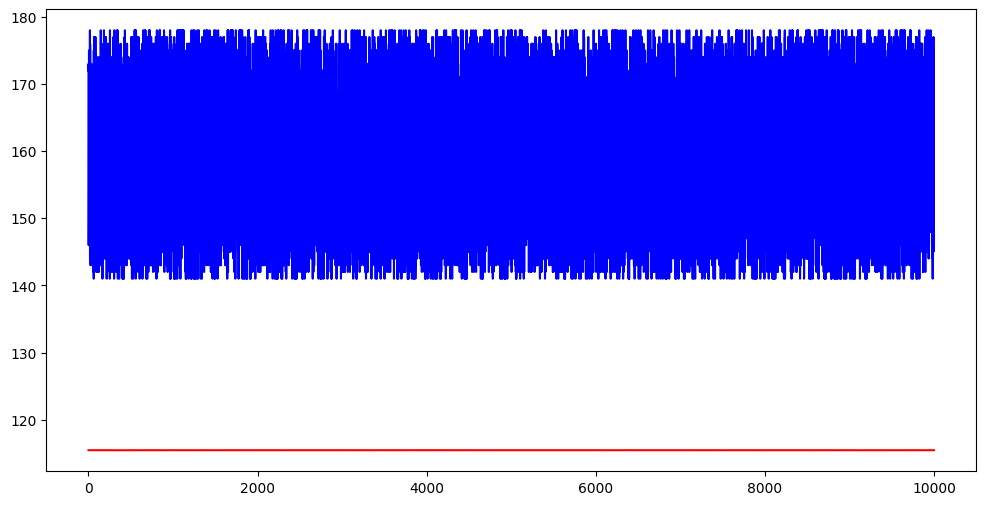

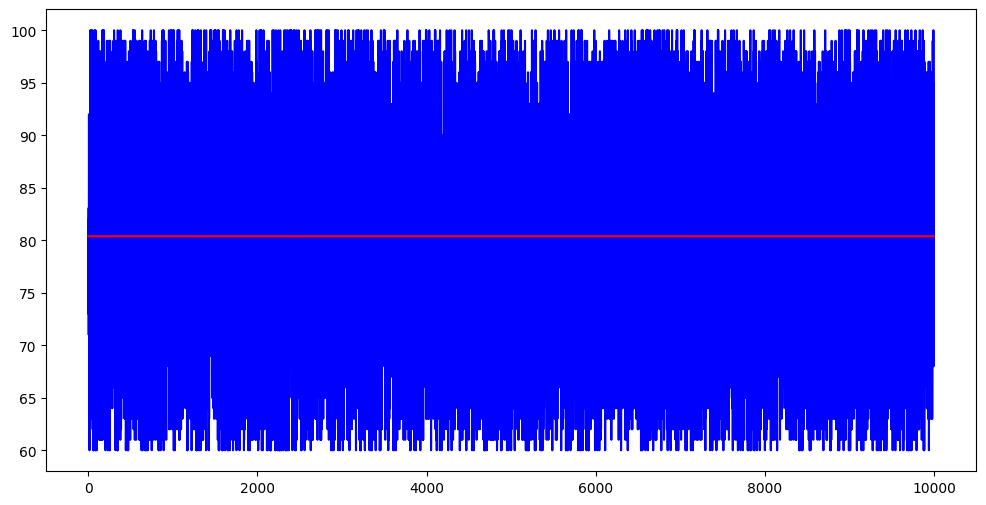

In [19]:
import matplotlib.pyplot as plt

def plot_2vectors(labels, predictions, title, xlabel, ylabel, save_as):
    """
    Plot two vectors (labels vs. predictions).
    """
    plt.figure(figsize=(12, 6))
    plt.plot(labels, 'b-', label='True Values')
    plt.plot(predictions, 'r-', label='Predictions')
    # plt.title(title)
    # plt.xlabel(xlabel)
    # plt.ylabel(ylabel)
    # plt.legend()
    # plt.grid(True)
    # plt.savefig(save_as)
    # plt.show()

# Use the LSTM model to predict on the test data
predictions = model_lstm.predict(X_test_scaled)

# Extracting the Systolic (S) and Diastolic (D) predictions
systolic_predictions = predictions[:, 0]
diastolic_predictions = predictions[:, 1]

# Plotting the results
plot_2vectors(Y_test_lstm[:, 0], systolic_predictions, "Systolic Blood Pressure (True vs Predicted)", "Samples", "Pressure", "systolic_plot.png")
plot_2vectors(Y_test_lstm[:, 1], diastolic_predictions, "Diastolic Blood Pressure (True vs Predicted)", "Samples", "Pressure", "diastolic_plot.png")


- First plot is systolic and secodn plot is diastolic

### Scaling of both features and labels

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='tanh', recurrent_activation='sigmoid', input_shape=(X_train_scaled.shape[1], 1)))
model_lstm.add(Dense(50, activation='relu'))
model_lstm.add(Dense(2))  # Two output units for S and D

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Training the LSTM model
desired_mae = 3
best_mae = float('inf')
patience = 10  # Number of epochs to wait if no improvement before stopping
wait = 0

for epoch in range(500):  # Maximum epochs
    print(f"\nEpoch {epoch+1}/500")

    # Train the model
    model_lstm.fit(X_train_scaled, Y_train_scaled, batch_size=32, epochs=1, verbose=1)
    # validation_data=(X_test_scaled, Y_test_scaled)

    # Evaluate the model's performance on the test set
    predictions = model_lstm.predict(X_test_scaled)
    mae_scores = mean_absolute_error(Y_test_scaled, predictions, multioutput='raw_values')
    print(f"Mean Absolute Error for S: {mae_scores[0]}, for D: {mae_scores[1]}")

    # Early stopping based on desired MAE
    if mae_scores[0] <= desired_mae and mae_scores[1] <= desired_mae:
        print("Desired MAE achieved. Stopping training.")
        break

    # Implementing patience for early stopping
    if mae_scores[0] < best_mae or mae_scores[1] < best_mae:
        best_mae = min(mae_scores)
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"MAE did not improve for {patience} consecutive epochs. Stopping training.")
            break



Epoch 1/500
313/313 [==============================] - 4s 10ms/step
Mean Absolute Error for S: 0.8842930711190802, for D: 0.25671812927484283
Desired MAE achieved. Stopping training.


In [8]:
predictions

array([[0.4772079 , 0.49163854],
       [0.49399287, 0.50487936],
       [0.46818846, 0.48700085],
       ...,
       [0.46005443, 0.4852464 ],
       [0.4581225 , 0.48377103],
       [0.44716263, 0.4762173 ]], dtype=float32)

In [12]:
predictions

array([[0.48955935, 0.48821163],
       [0.49879846, 0.49253297],
       [0.48071066, 0.48370147],
       ...,
       [0.46981102, 0.47853607],
       [0.46939856, 0.4787319 ],
       [0.47797728, 0.4805615 ]], dtype=float32)

313/313 [==============================] - 4s 11ms/step


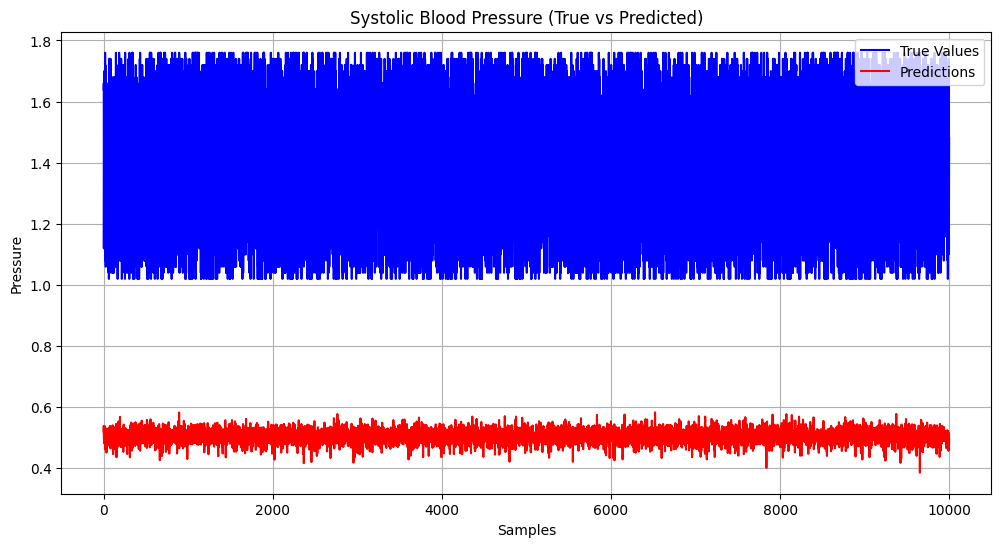

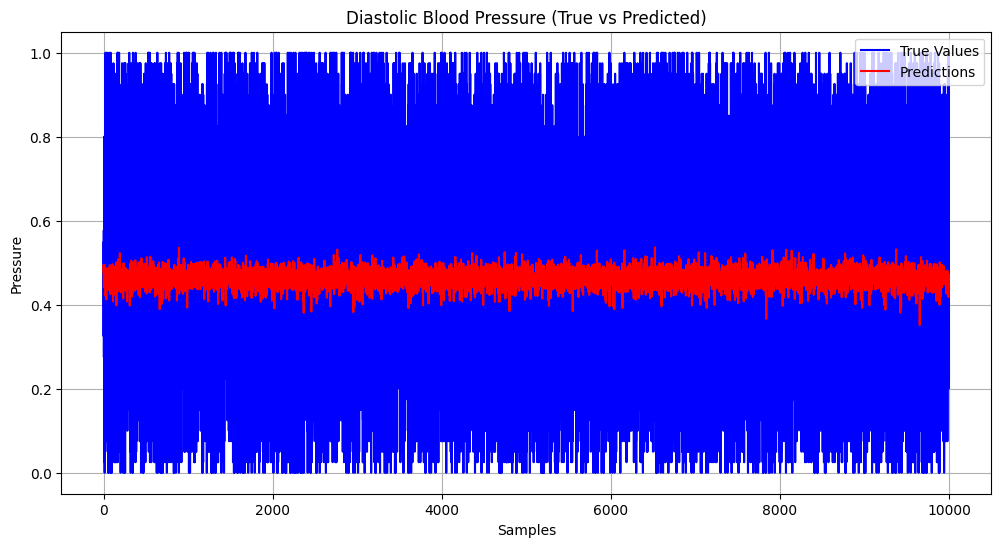

In [22]:
import matplotlib.pyplot as plt

def plot_2vectors(labels, predictions, title, xlabel, ylabel, save_as):
    """
    Plot two vectors (labels vs. predictions).
    """
    plt.figure(figsize=(12, 6))
    plt.plot(labels, 'b-', label='True Values')
    plt.plot(predictions, 'r-', label='Predictions')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(save_as)
    plt.show()

# Use the LSTM model to predict on the test data
predictions = model_lstm.predict(X_test_scaled)

# Extracting the Systolic (S) and Diastolic (D) predictions
systolic_predictions = predictions[:, 0]
diastolic_predictions = predictions[:, 1]

# Plotting the results
plot_2vectors(Y_test_scaled[:, 0], systolic_predictions, "Systolic Blood Pressure (True vs Predicted)", "Samples", "Pressure", "systolic_plot.png")
plot_2vectors(Y_test_scaled[:, 1], diastolic_predictions, "Diastolic Blood Pressure (True vs Predicted)", "Samples", "Pressure", "diastolic_plot.png")
